In [1]:
# Imports
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sqlalchemy import create_engine, inspect, text, func, desc

# ORM Stuff
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base

#Style
from matplotlib import style
style.use('fivethirtyeight')

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [3]:
# Create the inspector and connect it to the engine, Cookie cutter from 10.2.8
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within the 'dow' table and its types
for table in tables:
    print(table)
    print("--------")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
--------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [4]:
 # Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [5]:
Station = Base.classes.station
Measurement = Base.classes.measurement

In [6]:
# Open the Threads
session = Session(engine) # ORM
conn = engine.connect() # Raw SQL/Pandas

In [7]:
#Look at data from station
query = text("""SELECT * from station""")
dfs = pd.read_sql(query, con=conn)
dfs

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [8]:
#Look at data from measurement
query = text("""SELECT * from measurement""")
dfm = pd.read_sql(query, con=conn)
dfm

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


# Exploratory Precipitation Analysis

In [9]:
#RAW SQL Find the most recent date in the data set.
query = text("""SELECT max(date) from measurement;""")
conn.execute(query).fetchall()

[('2017-08-23',)]

In [10]:
#Using the ORM 
session.query(func.max(Measurement.date)).all()

[('2017-08-23',)]

In [11]:
#Percipitation data using raw SQL
query = text("""SELECT
                    id,
                    station,
                    date,
                    prcp
                FROM
                    measurement
                WHERE
                    date >='2016-08-23'
                ORDER BY 
                    date;""")
df1a = pd.read_sql(query, con=conn)
df1a.head()

,id,station,date,prcp
0,2364,USC00519397,2016-08-23,0.00
1,5091,USC00513117,2016-08-23,0.15
2,7331,USC00514830,2016-08-23,0.05
3,8825,USC00517948,2016-08-23,NaN
4,11851,USC00519523,2016-08-23,0.02


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date

#ORM Query
rows = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date)
df1b=pd.DataFrame(rows)
df1b.head()

,id,station,date,prcp
0,2364,USC00519397,2016-08-23,0.00
1,5091,USC00513117,2016-08-23,0.15
2,7331,USC00514830,2016-08-23,0.05
3,8825,USC00517948,2016-08-23,NaN
4,11851,USC00519523,2016-08-23,0.02


<Figure size 1000x600 with 0 Axes>

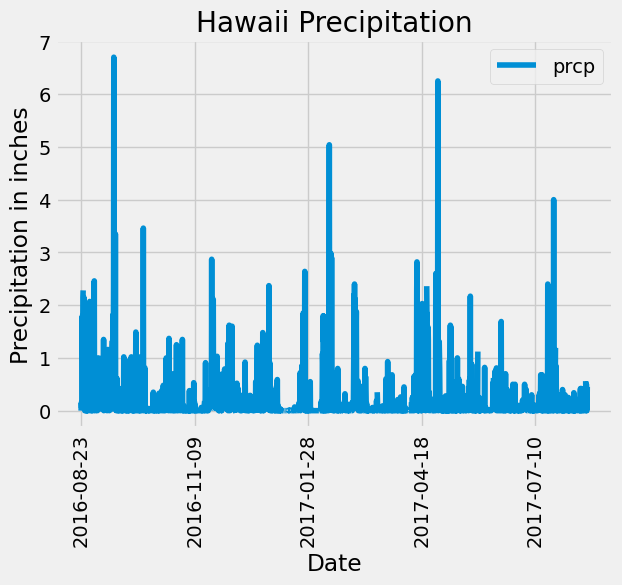

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10,6))
df1b.plot(x="date", y="prcp", rot=90)
plt.ylabel("Precipitation in inches")
plt.xlabel("Date")
plt.title("Hawaii Precipitation")
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df1b.prcp.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
#Thanks Xpert
session.query(func.count(func.distinct(Station.id))).scalar()

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
#Look at most active station using Raw SQL
query = text("""SELECT
                    id,
                    station,
                    date,
                    prcp,
                    tobs
                FROM
                    measurement
                WHERE
                    station = 'USC00519281'
                ORDER BY 
                    date;""")
df2a = pd.read_sql(query, con=conn)
df2a.head()

,id,station,date,prcp,tobs
0,12188,USC00519281,2010-01-01,0.15,70.0
1,12189,USC00519281,2010-01-02,0.00,62.0
2,12190,USC00519281,2010-01-03,0.00,74.0
3,12191,USC00519281,2010-01-04,0.00,75.0
4,12192,USC00519281,2010-01-05,0.00,74.0


In [18]:
#Look at most active station using ORM
rows = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').all()
df2b = pd.DataFrame(rows)
df2b.head()

,station,date,tobs
0,USC00519281,2010-01-01,70.0
1,USC00519281,2010-01-02,62.0
2,USC00519281,2010-01-03,74.0
3,USC00519281,2010-01-04,75.0
4,USC00519281,2010-01-05,74.0


In [19]:
# Using the most active station id from the previous query:

#calculate the lowest temp
min = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
min 

[(54.0,)]

In [20]:
#Calculation the highest temp
max = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
max

[(85.0,)]

In [21]:
#Calc average temperature
session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(71.66378066378067,)]

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
rows = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= '2016-08-23').all()
df3 = pd.DataFrame(rows)
df3

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


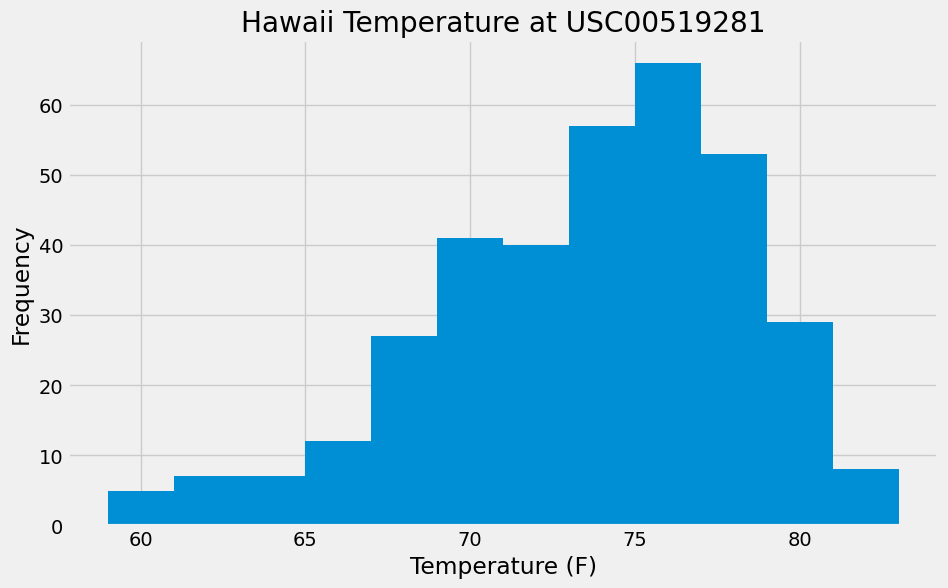

In [27]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

plt.figure(figsize=(10,6))
plt.hist(df3.tobs, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.title("Hawaii Temperature at USC00519281")
plt.show()

# Close Session

In [29]:
# Close Session
session.close()
conn.close()

In [30]:
#Dispose the engine
engine.dispose()